# 2022-05-02• STA mean vs peak-to-peak

## Setup

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


## Params

In [37]:
N_excs = [
    4,   # => N_inh = 1
    17,  # Same as in `previous_N_30_input`.
#     80,
#     320,
#     1280,
#     5200,  
];

In [38]:
get_params(N_exc) = ExperimentParams(
    sim = SimParams(
        duration = 10 * minutes,
        imaging = get_VI_params_for(cortical_RS, spike_SNR = Inf),
        input = PoissonInputParams(; N_exc),
    ),
    conntest = ConnTestParams(STA_test_statistic="ptp")
);

In [39]:
paramsets = get_params.(N_excs);

In [40]:
dumps(paramsets[1])

ExperimentParams
  rngseed: 22022022
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 4
      N_inh: 1
      N_conn: 5
      N: 105
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      avg_stim_rate_exc: 1.0e-10
      avg_stim_rate_inh: 4.0e-10
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: Inf
      spike_SNR_dB: Inf
      spike_height: 0.095
      σ_noise: 0.0
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    STA_test_statistic: ptp
    rngseed: 0
  evaluation: EvaluationParams
    α: 0.05
    num_tested_

## Run

In [42]:
perfs = Vector()
for paramset in paramsets
    num_inputs = paramset.sim.input.N_conn
    @show num_inputs
    perf = performance_for(paramset)
    @show perf
    push!(perfs, perf)
    println()
end

num_inputs = 5
Running simulation: 100%|███████████████████████████████| Time: 0:00:15
Testing connections: 100%|██████████████████████████████| Time: 0:00:06
perf = (TPR_exc = 1.0, TPR_inh = 0.0, FPR = 0.07499999999999996)

num_inputs = 21
Running simulation: 100%|███████████████████████████████| Time: 0:00:16
Testing connections: 100%|██████████████████████████████| Time: 0:00:08
perf = (TPR_exc = 1.0, TPR_inh = 0.0, FPR = 0.07499999999999996)



## Plot results

In [25]:
import PyPlot

In [26]:
using VoltageToMap.Plot

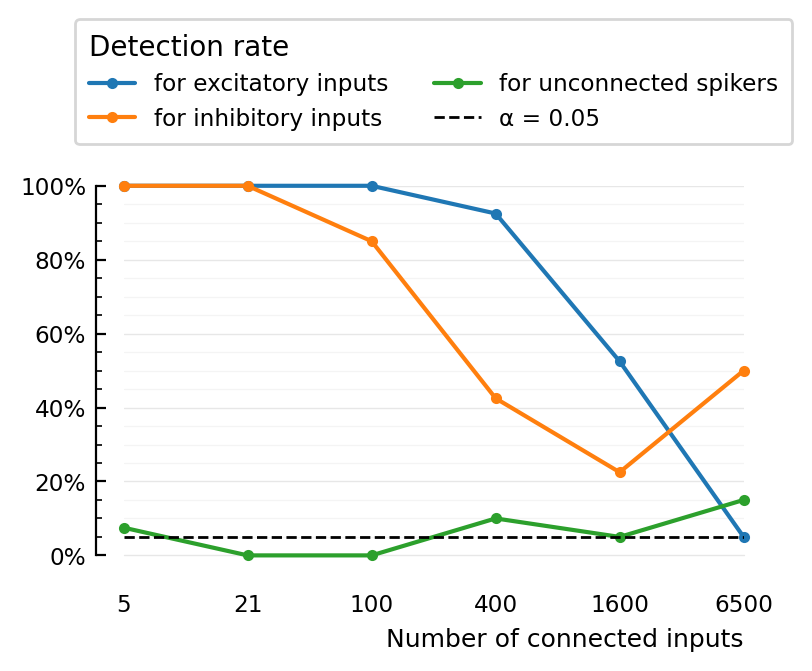

In [32]:
xlabels = [p.sim.input.N_conn for p in paramsets]
xticks = [1:length(xlabels);]
plot_detection_rate(detection_rate; kw...) = plot(
    xticks,
    detection_rate,
    ".-";
    ylim=(0, 1),
    xminorticks=false,
    clip_on=false,
    kw...
)
ax = plot_detection_rate([p.TPR_exc for p in perfs], label="for excitatory inputs")
     plot_detection_rate([p.TPR_inh for p in perfs], label="for inhibitory inputs")
     plot_detection_rate([p.FPR for p in perfs], label="for unconnected spikers")

@unpack α = paramsets[1].evaluation
ax.axhline(α, color="black", zorder=3, lw=1, linestyle="dashed", label=f"α = {α:.3G}")

# We don't use our `set`, as that undoes our `xminorticks=false` command (bug).
ax.set_xticks(xticks, xlabels)
ax.set_xlabel("Number of connected inputs")
ax.yaxis.set_major_formatter(PyPlot.matplotlib.ticker.PercentFormatter(xmax=1))
ax.xaxis.grid(false)
ax.tick_params(bottom=false)
ax.spines["bottom"].set_visible(false)
l = ax.legend(title="Detection rate", ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1.1));
l._legend_box.align = "left";

## [experiment with JLD]

In [19]:
paramset = paramsets[1]
dir = joinpath(homedir(), ".phdcache")
mkpath(dir)
path = joinpath(dir, "$(hash(paramset)).hdf5")

"C:\\Users\\lpxtf3\\.phdcache\\14612827808137850469.hdf5"

In [20]:
@save path paramset